# **Object detection using R-CNN model on Vedai dataset**

In [1]:
import os,cv2,keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from PIL import Image

**clone vedai dataset from github**

In [2]:
!git clone https://github.com/mr8bit/vedai.git
%cd /content/vedai
!python xml_to_csv.py

Cloning into 'vedai'...
remote: Enumerating objects: 8913, done.
remote: Total 8913 (delta 0), reused 0 (delta 0), pack-reused 8913
Receiving objects: 100% (8913/8913), 1.50 GiB | 32.25 MiB/s, done.
Resolving deltas: 100% (3671/3671), done.
/content/vedai
Work on: /content/vedai/images/train/751.xml
Work on: /content/vedai/images/train/11416.xml
Work on: /content/vedai/images/train/15915.xml
Work on: /content/vedai/images/train/345.xml
Work on: /content/vedai/images/train/490.xml
Work on: /content/vedai/images/train/3809.xml
Work on: /content/vedai/images/train/2303.xml
Work on: /content/vedai/images/train/1770.xml
Work on: /content/vedai/images/train/20991.xml
Work on: /content/vedai/images/train/20986.xml
Work on: /content/vedai/images/train/20962.xml
Work on: /content/vedai/images/train/278.xml
Work on: /content/vedai/images/train/10660.xml
Work on: /content/vedai/images/train/10852.xml
Work on: /content/vedai/images/train/21476.xml
Work on: /content/vedai/images/train/509.xml
Work 

In [3]:
train_path  = "/content/vedai/images/train"
test_path  = "/content/vedai/images/test"
annot = "/content/vedai/data"

a = os.listdir(train_path)
for item in a:
    if item.endswith(".xml"):
        os.remove(os.path.join(train_path, item))

b = os.listdir(test_path)
for item in b:
    if item.endswith(".xml"):
        os.remove(os.path.join(test_path, item))

**show the first image with its bounding box**

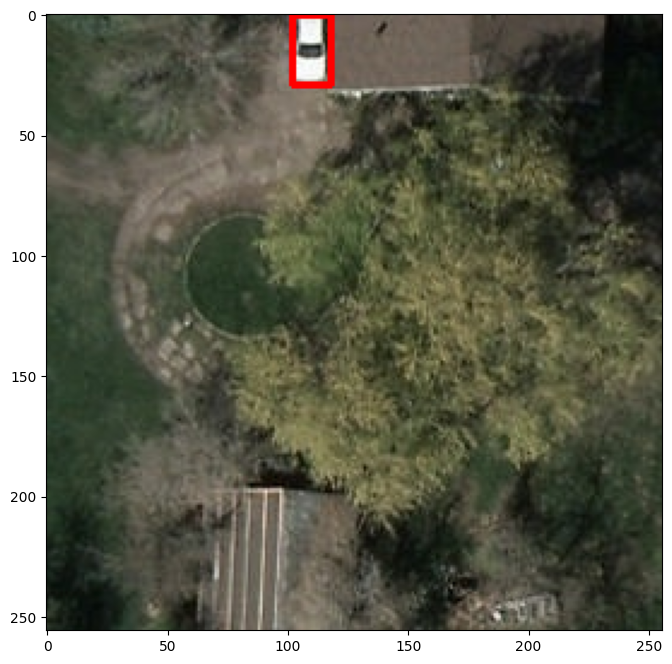

In [4]:
Index = os.listdir(train_path)[1]
filename = os.path.join(train_path , Index)
img = np.array(Image.open(filename))
df = pd.read_csv(os.path.join(annot , 'train_labels.csv'))
df = df[df[df.columns[0]] == Index ]

for row in df.iterrows():
    x1  = row[1][4]
    y1  = row[1][5]
    x2  = row[1][6]
    y2  = row[1][7]
    cv2.rectangle(img,(x1,y1),(x2,y2),(255,0,0), 2)
plt.figure(figsize=(8 , 8))
plt.imshow(img)

**using Selective Search algorithm for the first image**

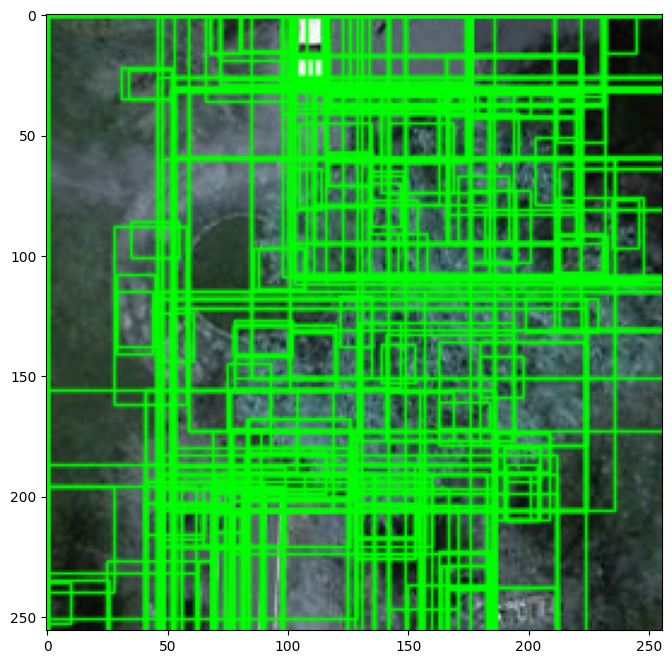

In [5]:
cv2.setUseOptimized(True)
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

im = cv2.imread(os.path.join(train_path,Index))
ss.setBaseImage(im)
ss.switchToSelectiveSearchFast()
rects = ss.process()
imOut = im.copy()
for i, rect in (enumerate(rects)):
    x, y, w, h = rect
    cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
plt.figure(figsize=(8 , 8))
plt.imshow(imOut)

**defining our metrix functions for keeping best bounding boxes**

In [6]:
def _interval_overlap(interval_a, interval_b):
	x1, x2 = interval_a
	x3, x4 = interval_b
	if x3 < x1:
		if x4 < x1:
			return 0
		else:
			return min(x2,x4) - x1
	else:
		if x2 < x3:
			 return 0
		else:
			return min(x2,x4) - x3

def IOU(box1, box2):
  x1 , y1 , x2 , y2 = box1
  x3 , y3 , x4 , y4 = box2
  intersect_w = _interval_overlap([x1 , x2] , [x3 , x4])
  intersect_h = _interval_overlap([y1 , y2] , [y3 , y4])
  intersect = intersect_w * intersect_h
  w1, h1 = x2 - x1 , y2 - y1
  w2, h2 = x4 - x3 , y4 -y3
  union = w1*h1 + w2*h2 - intersect
  return float(intersect) / union

**run Selective search algorithm on each training images to propose 2000 regions**

In [7]:
import time

if not os.path.exists('train_images.npy'):

    # At the end of below code we will have our train data in these lists
    train_images=[]
    train_labels=[]

    df = pd.read_csv(os.path.join(annot , 'train_labels.csv'))
    im_df = df.drop_duplicates(subset=df.columns[0])

    # df.head()

    start = time.time()

    for i, img in im_df.iterrows():

        if i < 20000:

            image = cv2.imread(os.path.join(train_path, img[0]))
            b_df = df[df[df.columns[0]] == img[0]]

            box_list = []

            for row in b_df.iterrows():
                x1  = row[1][4]
                y1  = row[1][5]
                x2  = row[1][6]
                y2  = row[1][7]
                box_list.append([x1, y1, x2, y2])

            ss.setBaseImage(image)  # setting given image as base image
            ss.switchToSelectiveSearchFast()  # running selective search on bae image
            ssresults = ss.process()  # processing to get the outputs
            imout = image.copy()

            counter = 0  # true sample
            falsecounter = 0  # negative sample
            flag = False  # complete
            tflag = False  # true ends
            bflag = False  # false ends

            for e, result in enumerate(ssresults):

                if e < 2000 and not flag:  # till 2000 to get top 2000 regions only

                    x, y, w, h = result

                    iou_list = [IOU(gtval, [x, y, x + w, y + h]) < 0.75 for gtval in box_list]

                    if all(iou_list):

                        if not bflag:
                            timage = imout[y:y+h , x:x+w]
                            resized = cv2.resize(timage, (224, 224), interpolation=cv2.INTER_AREA)
                            train_images.append(resized)
                            train_labels.append(0)
                            falsecounter += 1

                    else:

                        if not tflag:
                            timage = imout[y:y+h , x:x+w]
                            resized = cv2.resize(timage, (224, 224), interpolation=cv2.INTER_AREA)
                            train_images.append(resized)
                            train_labels.append(1)
                            counter += 1

                    bflag = False if falsecounter < len(box_list) else True
                    tflag = False if counter < len(box_list) else True

                    flag = tflag and bflag

        else:
            break

    end = time.time()

    print(f'elapsed time of generating training images : {end - start}')

elapsed time of generating training images : 1155.8579647541046


**some random regions of train images to show our bounding boxes that we chosen from proposals**

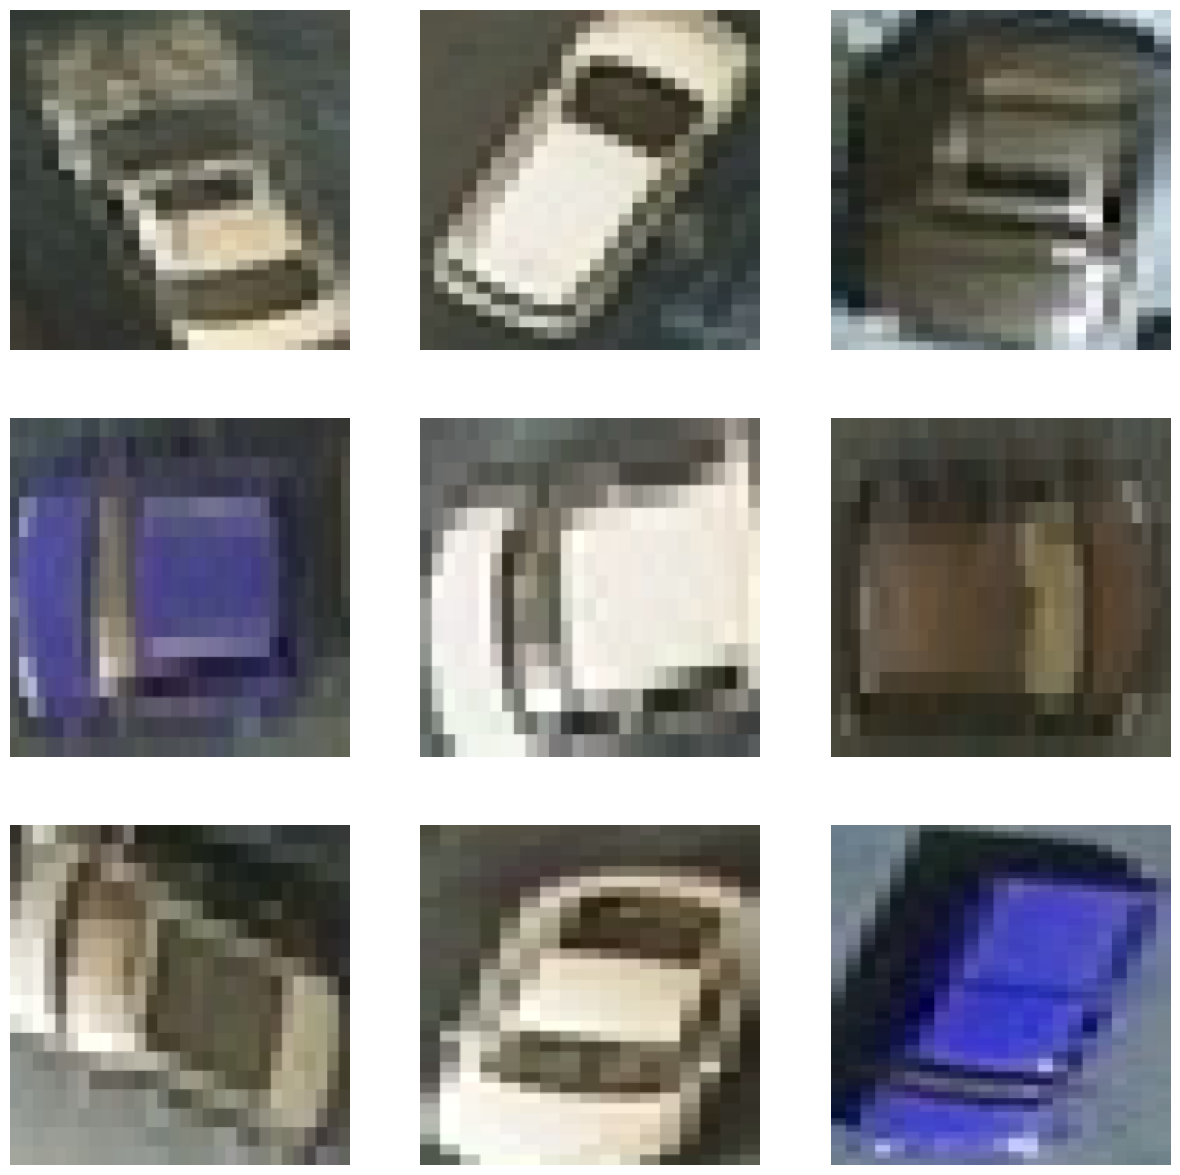

In [9]:
import random
if not os.path.exists('train_images.npy'):
    cars = [ i for i in range(len(train_labels)) if train_labels[i] == 1 ]
    sample_list = random.choices(cars, k=9)

if not os.path.exists('train_images.npy'):
    plt.figure(figsize=(15, 15))

    for idx , im_name in enumerate(sample_list):
        plt.subplot(330 + idx + 1)
        im = train_images[im_name]
        plt.axis('off')
        plt.imshow(im)
    plt.show()

**saving train imeges with their proposed bounding boxes and their ground truth (labels)**

In [10]:
if not os.path.exists('train_images.npy'):
    X_new = np.array(train_images)
    Y_new = np.array(train_labels)
    np.save('train_images.npy' , X_new)
    np.save('train_labels.npy' , Y_new)
else:
    X_new = np.load('train_images.npy')
    Y_new = np.load('train_labels.npy')

# **train R-CNN network for object detection task**

In [11]:
from keras.layers import Dense
from keras import Model
from keras import optimizers

vgg = tf.keras.applications.vgg16.VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)
for layer in vgg.layers[:-2]:
  layer.trainable = False
x = vgg.get_layer('fc2')
last_output =  x.output
x = tf.keras.layers.Dense(1,activation = 'sigmoid')(last_output)
model = tf.keras.Model(vgg.input,x)
model.compile(optimizer = "adam",
              loss = 'binary_crossentropy',
              metrics = ['acc'])

553467096/553467096 [==============================] - 3s 0us/step


In [12]:
model.summary()
history = model.fit(X_new,Y_new,batch_size = 64,epochs = 5, verbose = 1,validation_split= 0.2,shuffle = True)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

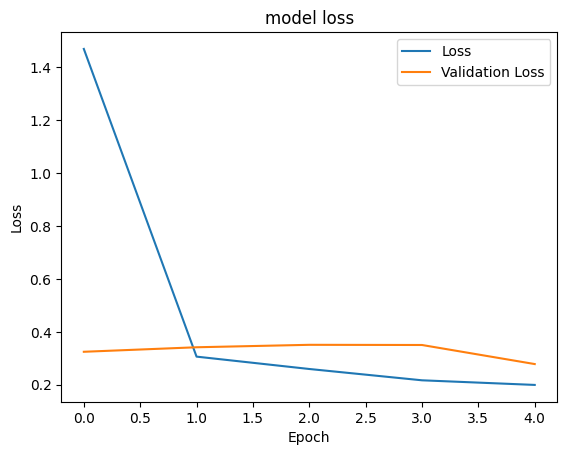

<Figure size 640x480 with 0 Axes>

In [13]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()
plt.savefig('chart loss.png')

# **evaluate model on test dataset**

In [14]:
def non_max_suppression_fast(boxes, overlapThresh):
	# if there are no boxes, return an empty list
	if len(boxes) == 0:
		return []
	# if the bounding boxes integers, convert them to floats --
	# this is important since we'll be doing a bunch of divisions
	if boxes.dtype.kind == "i":
		boxes = boxes.astype("float")
	# initialize the list of picked indexes
	pick = []
	# grab the coordinates of the bounding boxes
	x1 = boxes[:,0]
	y1 = boxes[:,1]
	x2 = boxes[:,2]
	y2 = boxes[:,3]
	# compute the area of the bounding boxes and sort the bounding
	# boxes by the bottom-right y-coordinate of the bounding box
	area = (x2 - x1 + 1) * (y2 - y1 + 1)
	idxs = np.argsort(y2)
	# keep looping while some indexes still remain in the indexes
	# list
	while len(idxs) > 0:
		# grab the last index in the indexes list and add the
		# index value to the list of picked indexes
		last = len(idxs) - 1
		i = idxs[last]
		pick.append(i)
		# find the largest (x, y) coordinates for the start of
		# the bounding box and the smallest (x, y) coordinates
		# for the end of the bounding box
		xx1 = np.maximum(x1[i], x1[idxs[:last]])
		yy1 = np.maximum(y1[i], y1[idxs[:last]])
		xx2 = np.minimum(x2[i], x2[idxs[:last]])
		yy2 = np.minimum(y2[i], y2[idxs[:last]])
		# compute the width and height of the bounding box
		w = np.maximum(0, xx2 - xx1 + 1)
		h = np.maximum(0, yy2 - yy1 + 1)
		# compute the ratio of overlap
		overlap = (w * h) / area[idxs[:last]]
		# delete all indexes from the index list that have
		idxs = np.delete(idxs, np.concatenate(([last],
			np.where(overlap > overlapThresh)[0])))
	# return only the bounding boxes that were picked using the
	# integer data type
	return boxes[pick].astype("int")

In [15]:
pred_columns_dict = {'Name' : [] ,
                     'x1' : [] ,
                     'y1' : [] ,
                     'x2' : [] ,
                     'y2' : [] ,
                     'label'  :[]}
pred_boxes = pd.DataFrame(pred_columns_dict)

In [16]:
import time

# At the end of below code we will have our train data in these lists
test_images=[]
test_labels=[]

df = pd.read_csv(os.path.join(annot , 'test_labels.csv'))
im_df = df.drop_duplicates(subset=df.columns[0])

# df.head()

start = time.time()

for i, img in im_df.iterrows():

    if i < 20000:

        image = cv2.imread(os.path.join(test_path, img[0]))
        b_df = df[df[df.columns[0]] == img[0]]

        box_list = []

        for row in b_df.iterrows():

            x1 = row[1][4]
            y1 = row[1][5]
            x2 = row[1][6]
            y2 = row[1][7]

            box_list.append([x1, y1, x2, y2])

        ss.setBaseImage(image)  # setting given image as base image
        ss.switchToSelectiveSearchFast()  # running selective search on bae image
        ssresults = ss.process()  # processing to get the outputs
        imout = image.copy()

        counter = 0  # true sample
        falsecounter = 0  # negative sample
        flag = False  # complete
        tflag = False  # true ends
        bflag = False  # false ends

        for bb in box_list:
            timage = imout[bb[1]:bb[3] , bb[0]:bb[2]]
            resized = cv2.resize(timage, (224, 224), interpolation=cv2.INTER_AREA)
            test_images.append(resized)
            test_labels.append(1)
            counter += 1

        for e, result in enumerate(ssresults):

            if e < 2000 and not flag:  # till 2000 to get top 2000 regions only

                x, y, w, h = result

                iou_list = [IOU(gtval, [x, y, x + w, y + h]) < 0.75 for gtval in box_list]

                if all(iou_list):

                    if not bflag:
                        timage = imout[y:y+h , x:x+w]
                        resized = cv2.resize(timage, (224, 224), interpolation=cv2.INTER_AREA)
                        test_images.append(resized)
                        test_labels.append(0)
                        falsecounter += 1

                bflag = False if falsecounter < len(box_list) else True
                tflag = False if counter < len(box_list) else True

                flag = tflag and bflag

    else:
        break

end = time.time()

print(f'elapsed time of generating training images : {end - start}')

elapsed time of generating training images : 33.32528352737427


In [17]:
if not os.path.exists('test_images.npy'):
    tnpy  = np.array(test_images)
    tlnpy = np.array(test_labels)
    np.save('test_images.npy' , tnpy)
    np.save('test_labels.npy' , tlnpy)
else:
    tnpy  = np.load('test_images.npy')
    tlnpy = np.load('test_labels.npy')

**model accuracy**

In [18]:
model.evaluate(tnpy , tlnpy)

5/5 [==============================] - 8s 1s/step - loss: 0.5181 - acc: 0.8571


[0.5180911421775818, 0.8571428656578064]